## Importing libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet

import copy 

#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import Isomap, LocallyLinearEmbedding

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN, KMeansSMOTE

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, fbeta_score, confusion_matrix, precision_recall_curve, auc, plot_precision_recall_curve, make_scorer

## 1. Loading data

### 1.1. Read data

In [3]:
bank_data = pd.read_csv('/content/drive/MyDrive/Applied Statistics Project/project_appstats/data/data.csv')

In [4]:
pd.set_option('display.max_columns', None)

In [ ]:
bank_data.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9.360000e+09,7.190000e+08,0.025484,0.0068

In [ ]:
bank_data.shape

(6819, 96)

#### It seems that the dataset has been scaled, let's check this

In [ ]:
(np.max(bank_data, axis=0) > 0.999).sum()

96

In [ ]:
(np.min(bank_data, axis=0) < 0.001).sum()

95

$\Rightarrow$ We can see that the dataset has been scaled

## 2. EDA

### 2.1. Check data information

In [ ]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

Through data.info(), we observed that we have a majority of "float64" data. The categorical data is distinguished as binary 1 and 0, thus stored as "int64". So, we first analize three features which datatype are "int64"

### 2.2. Features Overview

In [ ]:
strange_features = bank_data.dtypes[bank_data.dtypes == "int64"].index
numeric_features = bank_data.dtypes[bank_data.dtypes == "float64"].index

print(bank_data[strange_features].columns.tolist())
print(len(strange_features))
print(len(numeric_features))

['Bankrupt?', ' Liability-Assets Flag', ' Net Income Flag']
3
93


#### 2.2.1. Liability-Assets Flag compared to Bankrupt

 Liability-Assets Flag  Bankrupt?
0                       0            6597
                        1             214
1                       1               6
                        0               2
dtype: int64


<AxesSubplot:xlabel=' Liability-Assets Flag', ylabel='count'>

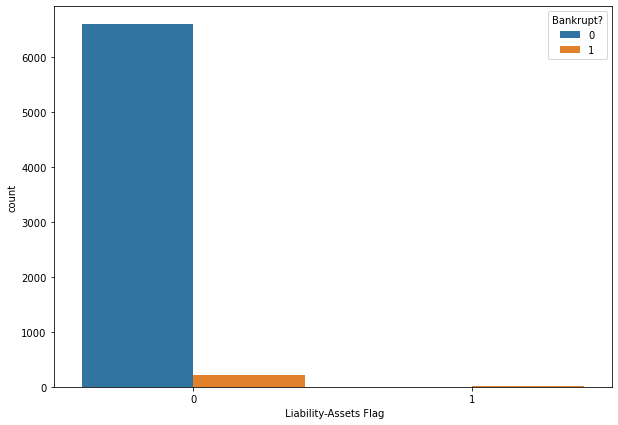

In [ ]:
print(bank_data[[" Liability-Assets Flag", "Bankrupt?"]].value_counts())
print("=======================")
plt.figure(figsize=(10, 7))
sns.countplot(x=" Liability-Assets Flag", huescorer="Bankrupt?", data=bank_data)

Explaination of `Liability-Assets`:
+ The `Liability-Assets` flag denotes the status of an organization, where if the `total liability exceeds total assets`, the flagged value will be 1, else the value is 0. A majority number of times, organizations/company's assets are more than their liabilities.

Brief:
+ A small portion of organizations suffers bankruptcy, although possessing more assets than their liabilities.

#### 2.2.2. Net Income Flag compared to Bankrupt

 Net Income Flag  Bankrupt?
1                 0            6599
                  1             220
dtype: int64


<AxesSubplot:xlabel=' Net Income Flag', ylabel='count'>

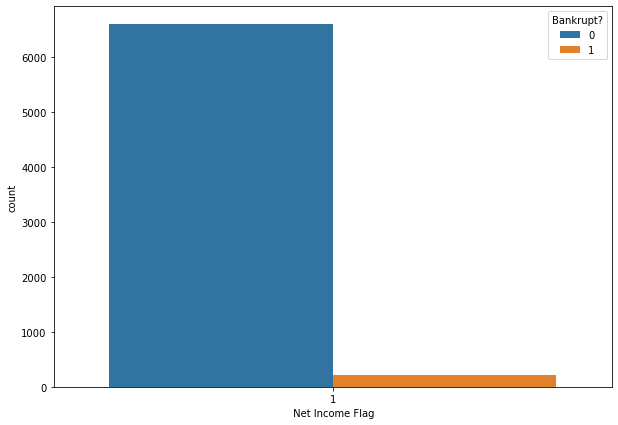

In [ ]:
print(bank_data[[" Net Income Flag", "Bankrupt?"]].value_counts())
print("=======================")
plt.figure(figsize=(10, 7))
sns.countplot(x=" Net Income Flag", hue="Bankrupt?", data=bank_data)

Explaination of `Net Income`:
+ The `Net Income` flag denotes the `status of an organization's income` in the last two years, where if the net income is negative for the past two years, the flagged value will be 1, else the value is 0. We observe that all the records have been exhibiting a loss for the past two years.

Brief:
* Many organizations that have suffered losses for the past two years have stabilized their business, thus avoiding bankruptcy.

## 3. Details analysis

### 3.1. Data description

In [ ]:
bank_data.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.11

### 3.2. Checking NAN

In [ ]:
[col for col in bank_data if bank_data[col].isnull().sum() > 0]

[]

$\Rightarrow$ There's no missing data

### 3.3. Checking duplicates

In [ ]:
bank_data.duplicated().sum()

0

$\Rightarrow$ There's no duplicated rows

### 3.4. Checking objective column

In [ ]:
bank_data['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

In [ ]:
print(f"Financially stable: {round(bank_data['Bankrupt?'].value_counts()[0]/len(bank_data) * 100,2)} %")
print(f"Financially unstable: {round(bank_data['Bankrupt?'].value_counts()[1]/len(bank_data) * 100,2)} %")

Financially stable: 96.77 %
Financially unstable: 3.23 %


/home/dungnasa/anaconda3/envs/LearnML/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Class Distributions \n (0: Financially Stable || 1: Financially Unstable)')

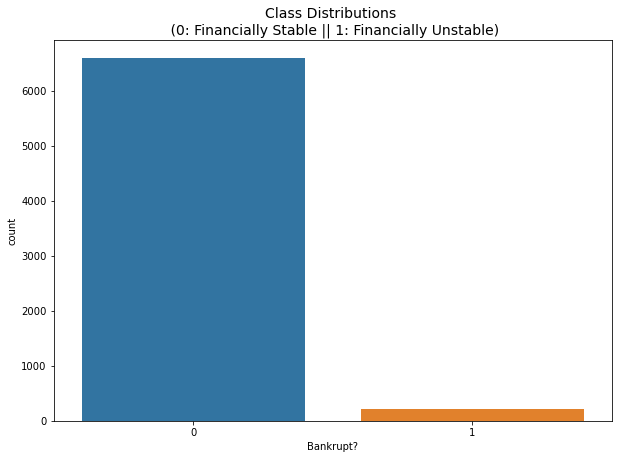

In [ ]:
plt.figure(figsize=(10, 7))
sns.countplot(bank_data['Bankrupt?'])
plt.title('Class Distributions \n (0: Financially Stable || 1: Financially Unstable)', fontsize=14)

$\Rightarrow$ We see that the dataset is highly imbalanced

### 3.5. Seeing correlations between features and target column

We analyze the top ten positively and negatively correlated attributes.

In [ ]:
positive_corr = bank_data[numeric_features].corrwith(bank_data["Bankrupt?"]).sort_values(ascending=False)[:10].index.tolist()
negative_corr = bank_data[numeric_features].corrwith(bank_data["Bankrupt?"]).sort_values()[:10].index.tolist()
positive_corr_df = bank_data[positive_corr + ["Bankrupt?"]]
negative_corr_df = bank_data[negative_corr + ["Bankrupt?"]]

In [ ]:
def corr_barplot(x_value, y_value):
    plt.figure(figsize=(15, 25))
    for i in range(1, 11):
        plt.subplot(5, 2, i)
        sns.barplot(x=x_value, y=y_value[i - 1], data=bank_data)

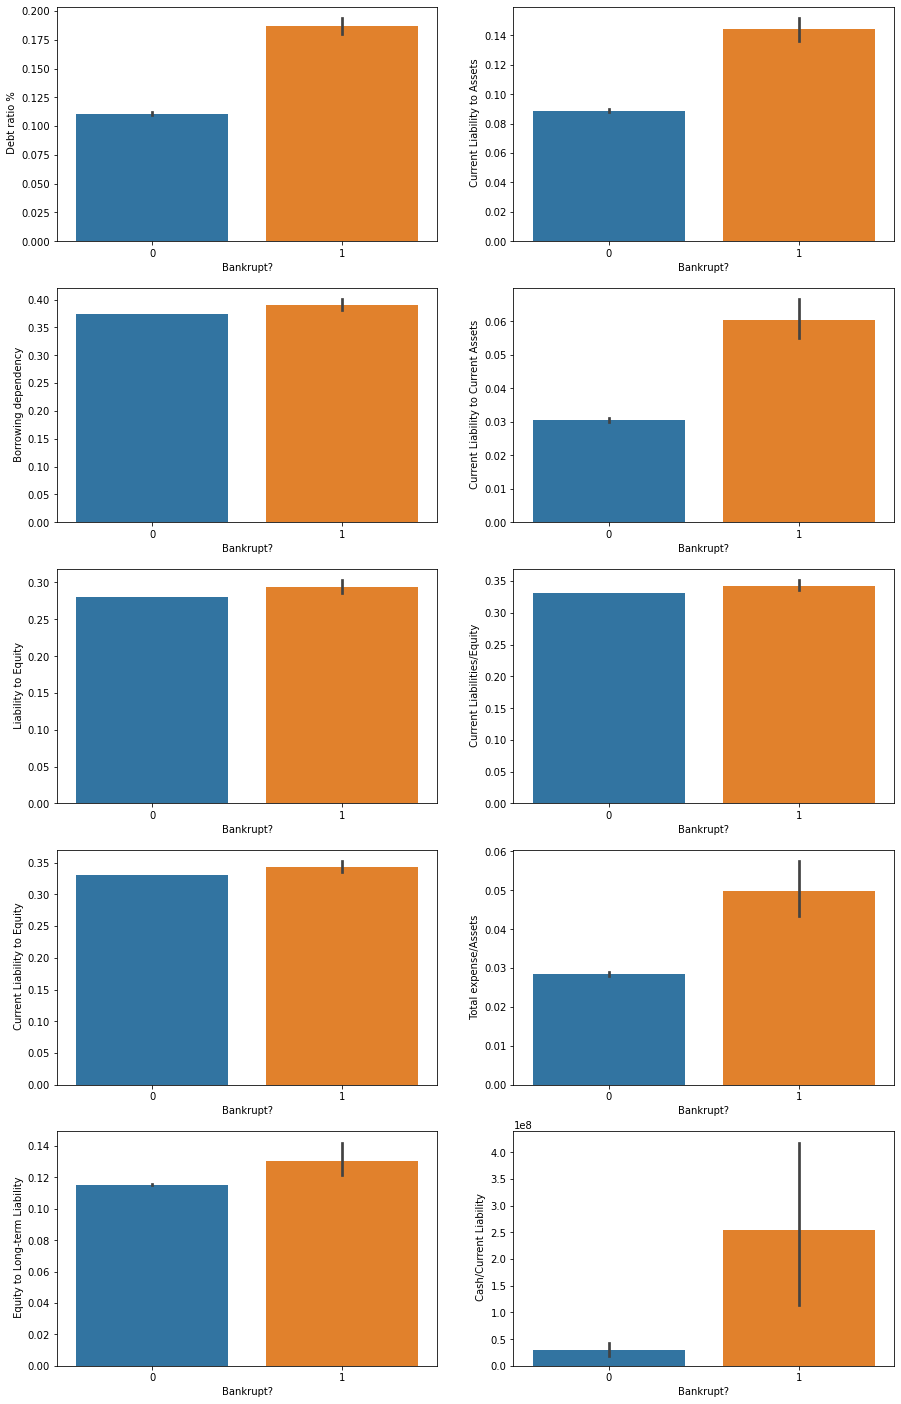

In [ ]:
x_value = positive_corr_df.columns.tolist()[-1]
y_value = positive_corr_df.columns.tolist()[:-1]
corr_barplot(x_value, y_value)

$\Rightarrow$ We see that three attributes - `Debt Ratio %`, `Current Liability To Assets`, `Current Liability To Current Assets` are commonly high in bankrupt organizations

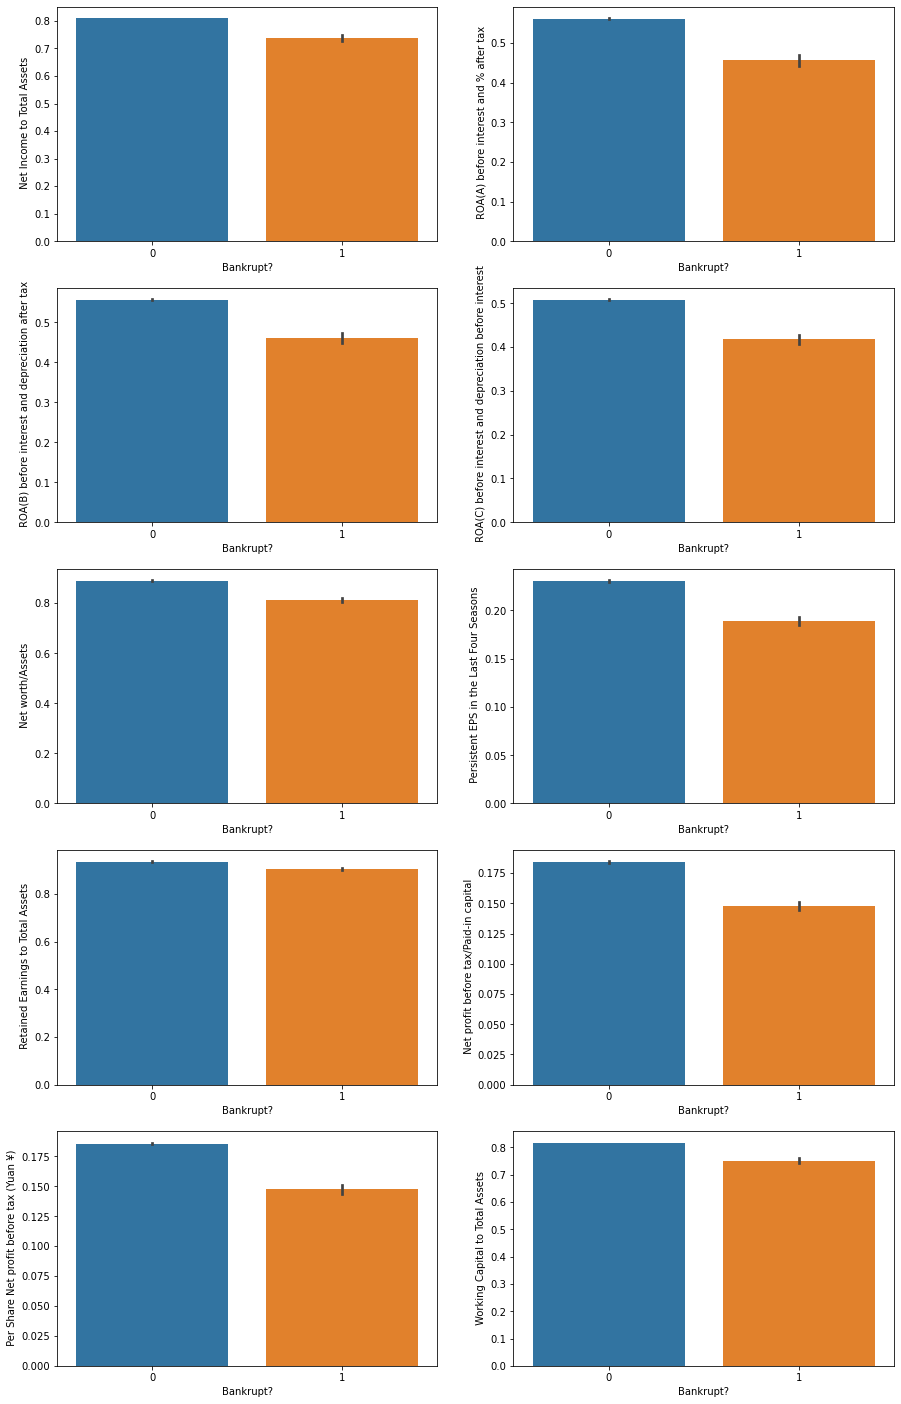

In [ ]:
x_value = negative_corr_df.columns.tolist()[-1]
y_value = negative_corr_df.columns.tolist()[:-1]

corr_barplot(x_value, y_value)

These attributes show us that the more the `assets` and `earing of a company`, the less likely is `the organization to be bankrupt`.

Let us check the relation of top ten positive and negative correlation attributes among each other

<AxesSubplot:>

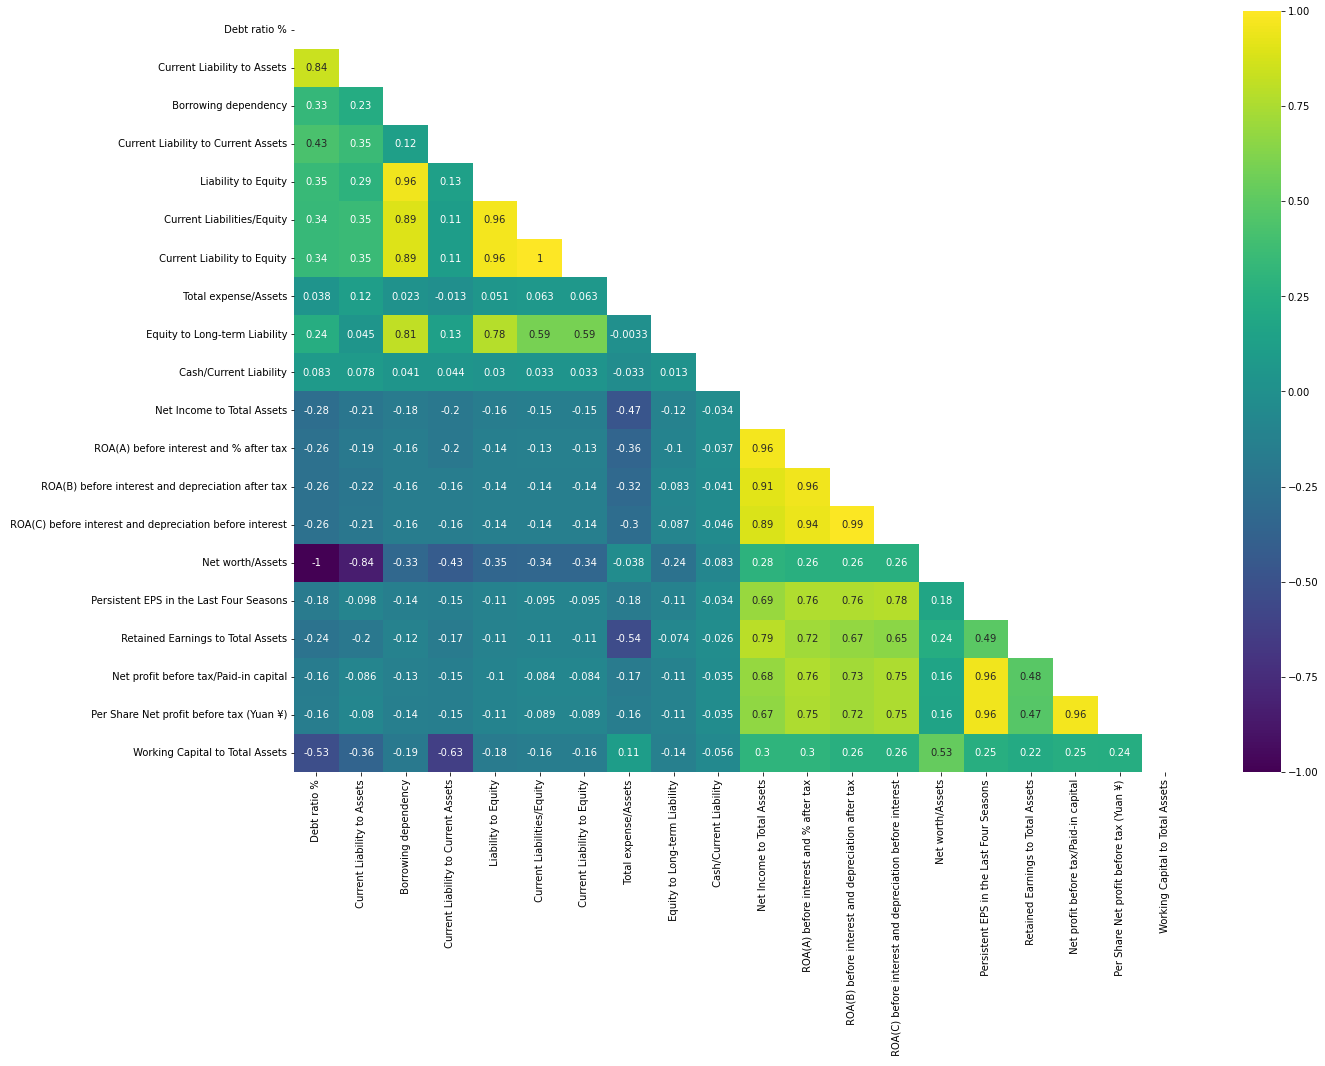

In [ ]:
relation = positive_corr + negative_corr
plt.figure(figsize=(20, 14))
mask = np.zeros_like(bank_data[relation].corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(bank_data[relation].corr(), mask=mask, annot=True, cmap='viridis')

### 3.6. Checking single valued features

In [ ]:
feature_value_counts = []
for feature in bank_data.columns[1:]:
    feature_value_counts.append([feature, bank_data[feature].value_counts().shape[0]])
feature_value_counts = sorted(feature_value_counts, key=lambda x: x[1])

In [ ]:
single_valued_features = [feature[0] for feature in feature_value_counts if feature[1] == 1]
print(single_valued_features)


[' Net Income Flag']


We will drop this feature because it has no effect on our model

In [ ]:
bank_data = bank_data.drop(columns=single_valued_features)

### 3.7. Checking outliers

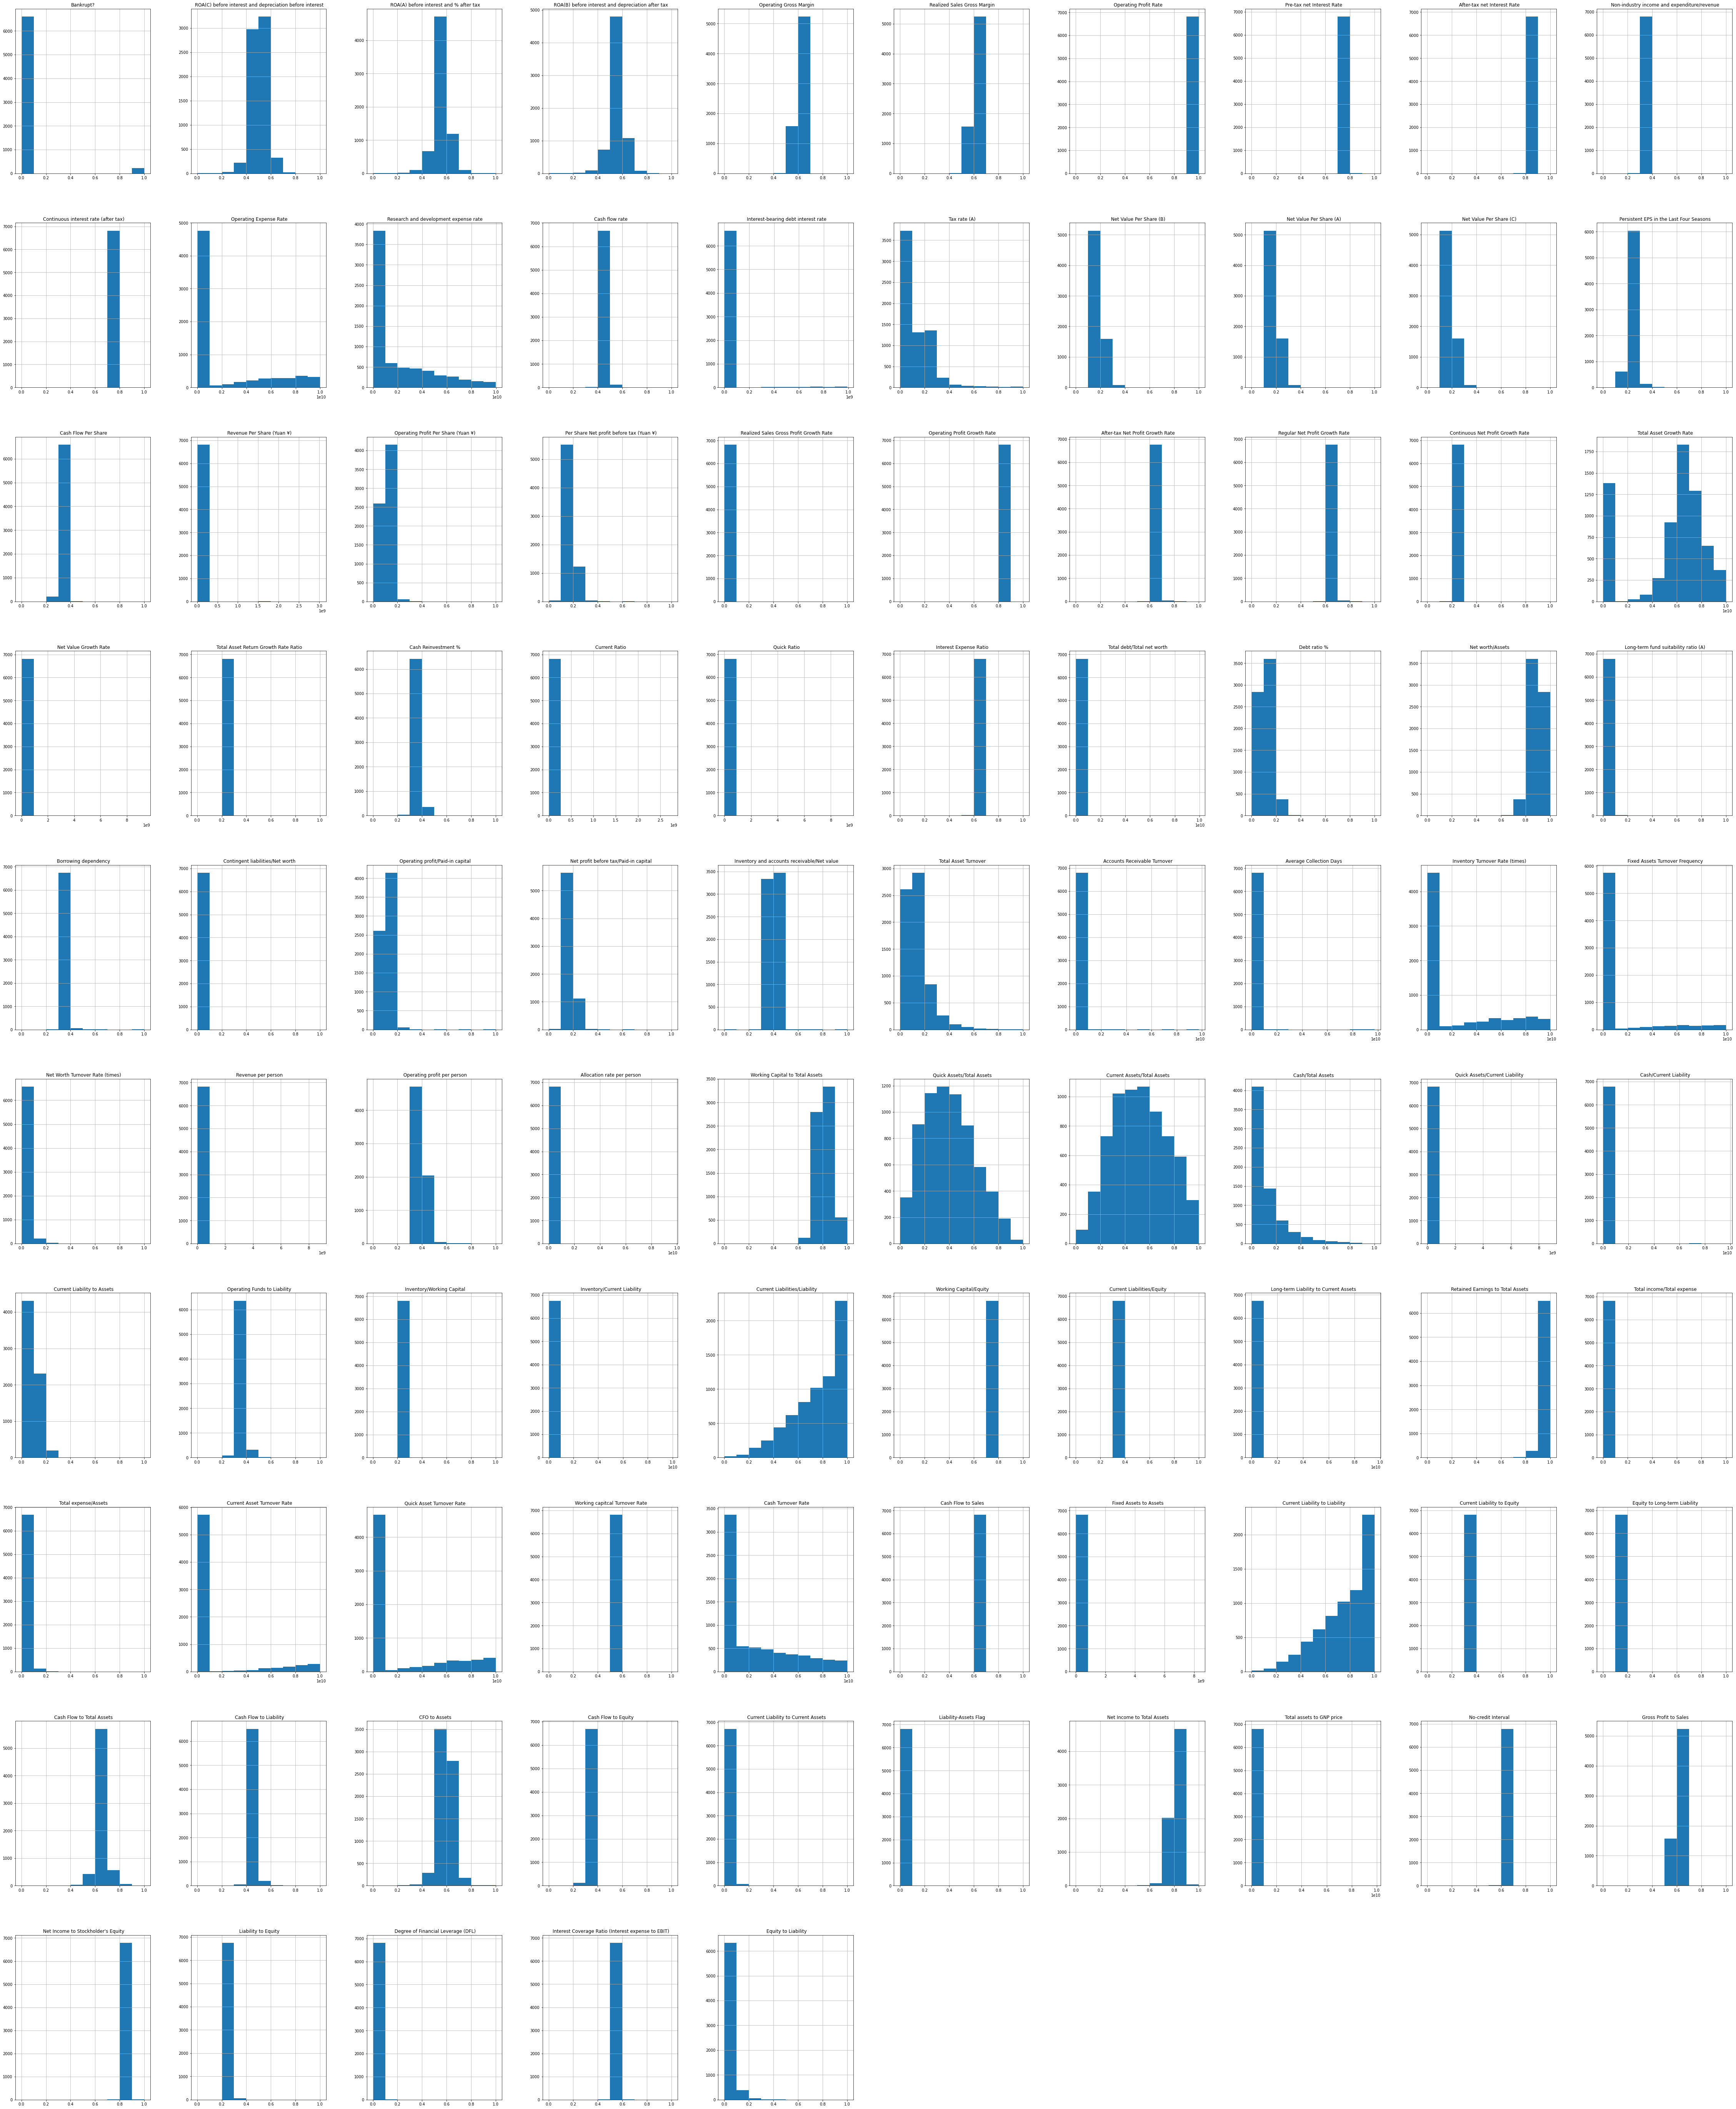

In [ ]:
bank_data.hist(figsize=(80, 100))
plt.show()

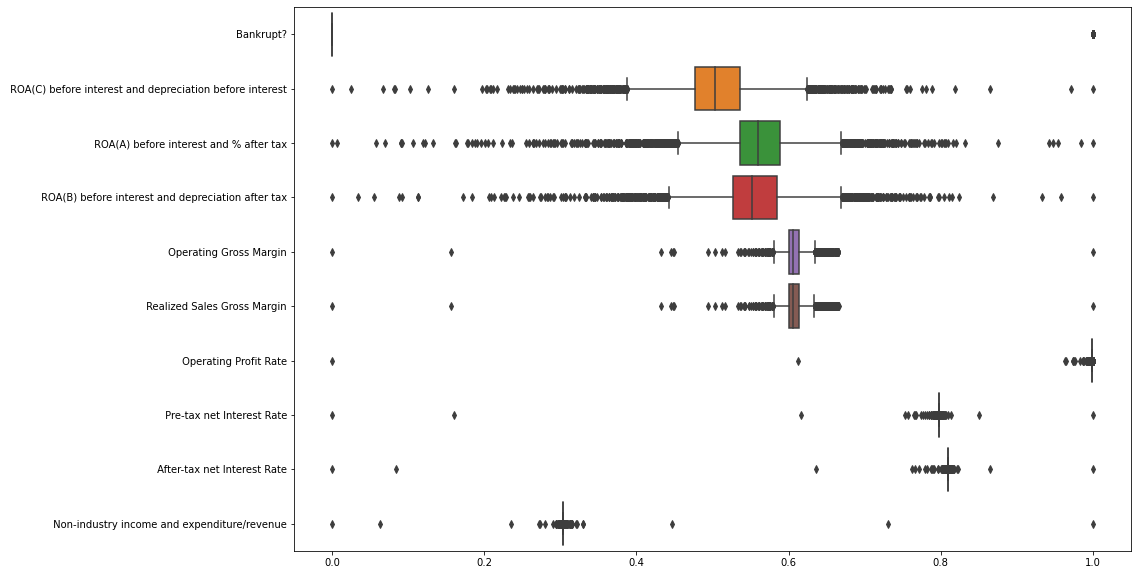

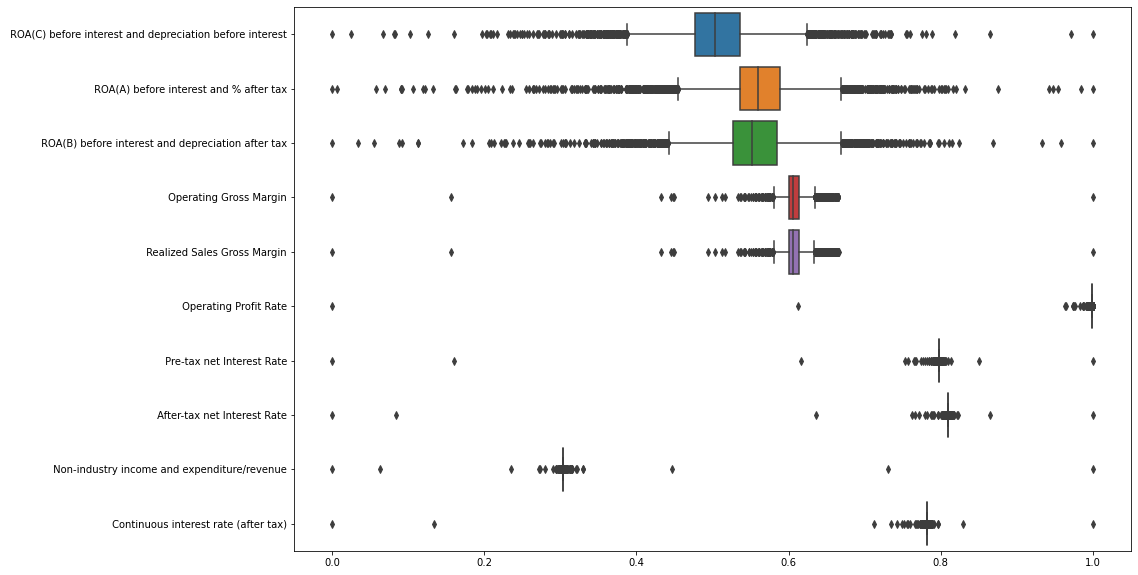

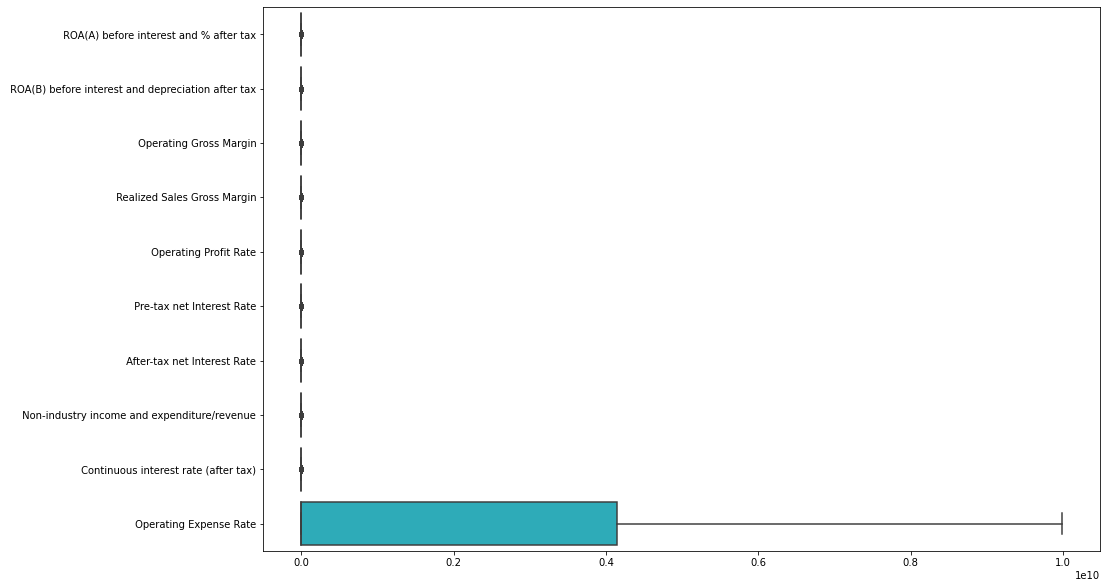

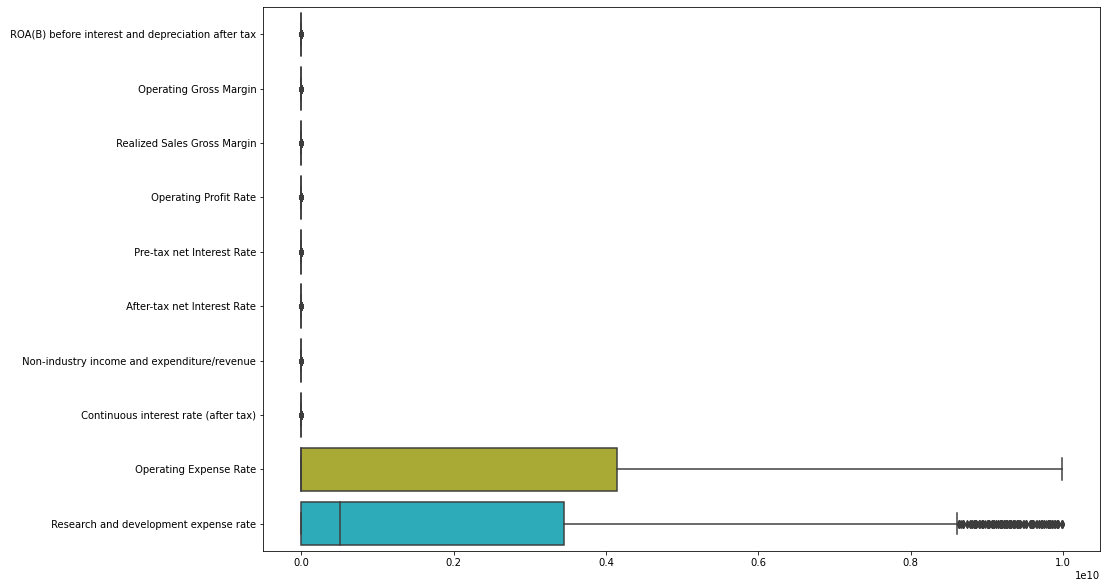

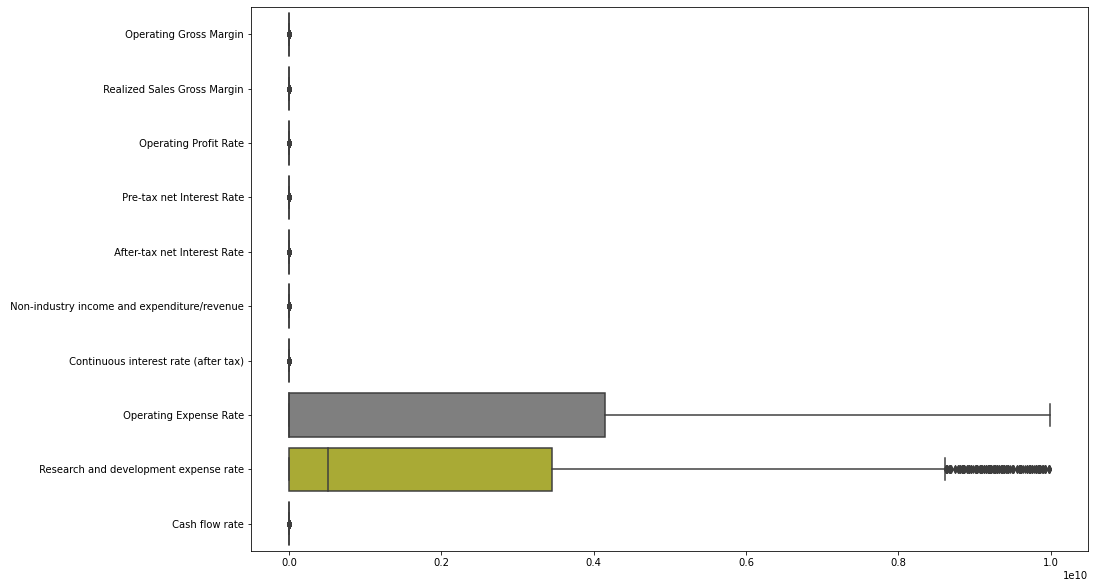

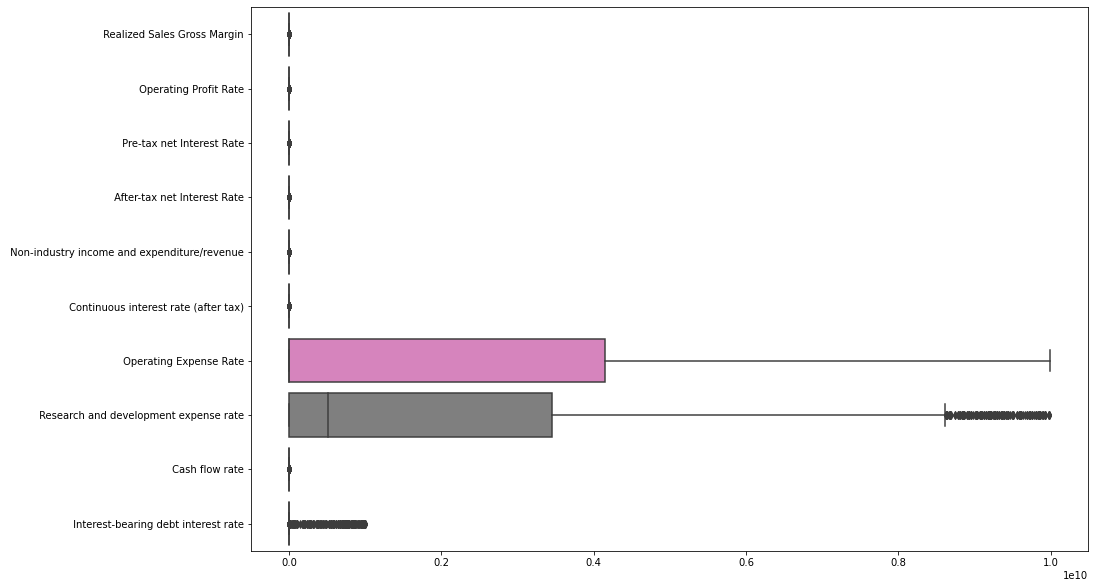

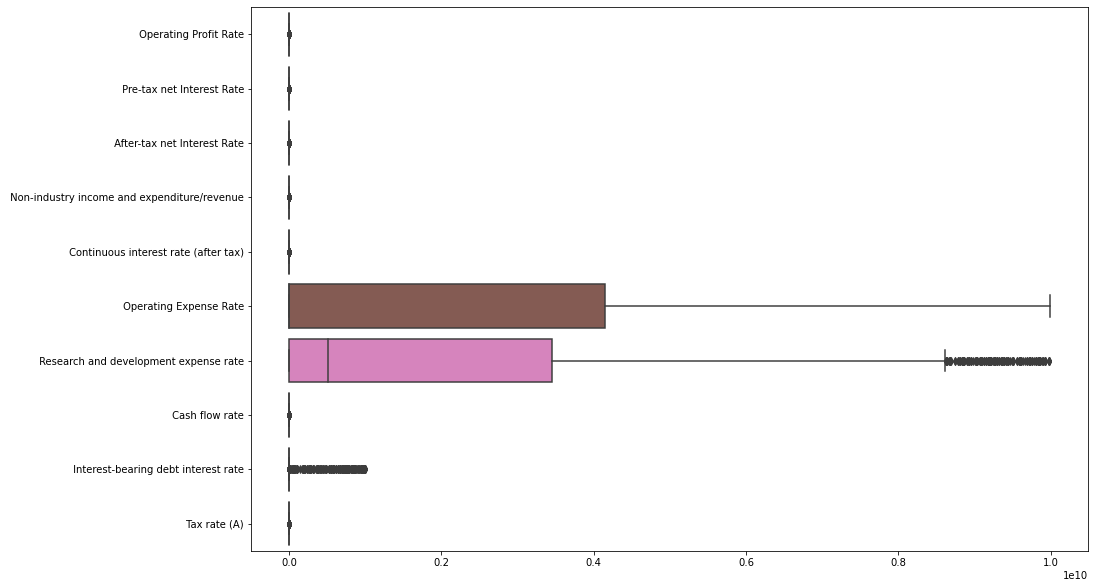

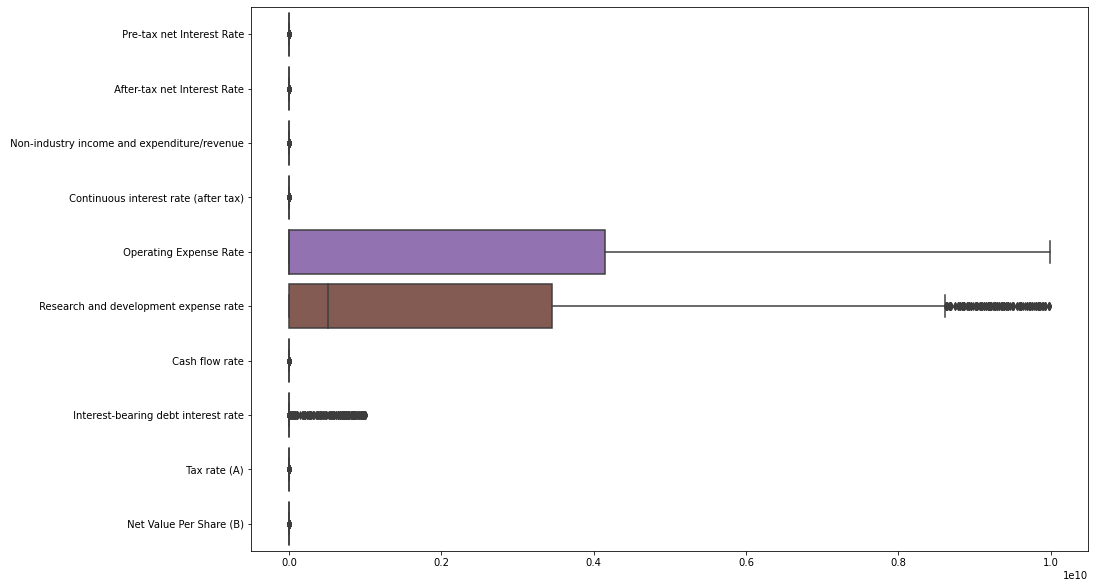

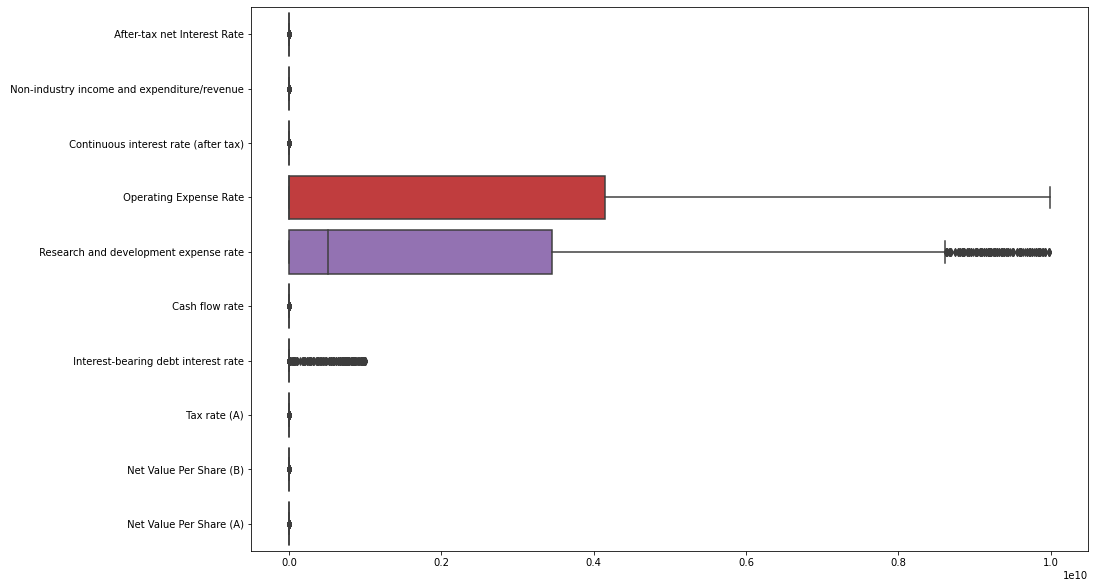

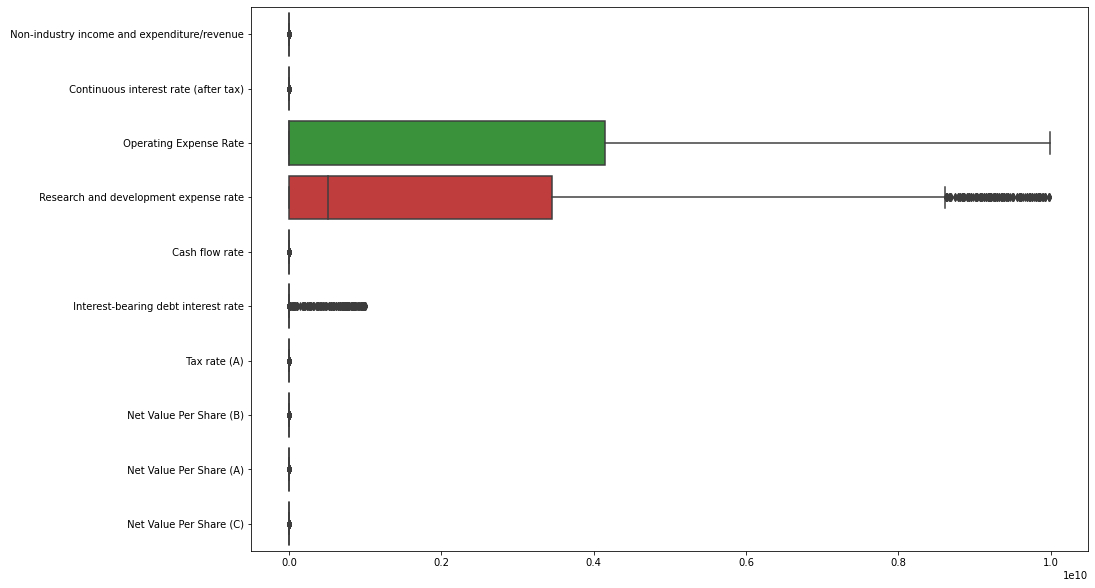

In [ ]:
for i in range(10):
    plt.figure(figsize=(15, 10))
    sns.boxplot(data=bank_data.iloc[:, i: i + 10], orient='h')
    plt.show()

Most of the data is rich on outliers, and in some other the values are located in just one bin

## Summary of Analysis

- The number of organizations that have gone bankrupt in 10 years between 1999 – 2000 is few.
- Several companies possess many assets, which is always a good sign for an organization.
- An organization cannot guarantee not being bankrupt, although owning several assets.
- The organizations in the dataset are running into losses for the past two years as their net income poses to be negative.
- Very few of the organizations that have had negative income in the past two years suffer from bankruptcy.
- It is observed that “Debt Ratio %, Current Liability To Assets, Current Liability To Current Assets" attributes are a few of the attributes that have a high correlation with the target attribute.
- An increase in the values of the attributes “Debt Ratio %, Current Liability To Assets, Current Liability To Current Assets” causes an organization to suffer heavy - losses, thus resulting in bankruptcy.
- An increase in the values of the attributes that have a negative correlation with the target attribute helps an organization avoid bankruptcy.
- There seems to be a relation between attributes that have a high correlation with the target attribute and a low correlation with the target attribute.
- We observed several correlations among the top 12 attributes, one of which being “Net Worth/Assets and Debt Ratio %” that is negatively correlated with one another.

## 4. Data processing

### 4.0. Prepare parameters

In [6]:
param_grid = {}

### 4.1. Handling outliers

#### 4.1.1. Outliers Detection

##### Tukey’s box plot method

In [ ]:
# Tukey’s box plot method
# Univariate outliers -> Can do this before dimentional reduction
def tukeys_method(df, variable):
    # Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3 - q1
    inner_fence = 1.5 * iqr
    outer_fence = 3 * iqr
    
    # inner fence lower and upper end
    inner_fence_le = q1 - inner_fence
    inner_fence_ue = q3 + inner_fence
    
    # outer fence lower and upper end
    outer_fence_le = q1 - outer_fence
    outer_fence_ue = q3 + outer_fence
    
    outliers_prob = []
    outliers_poss = []
    for index, x in enumerate(df[variable]):
        if x <= outer_fence_le or x >= outer_fence_ue:
            outliers_prob.append(index)
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_poss.append(index)
    return outliers_prob, outliers_poss
        
tukeys_method_outliers = []
for feature in bank_data.iloc[:, 1:].columns:
    probable_outliers_indexes, possible_outliers_indexes = tukeys_method(bank_data, feature)
    probable_possible_indexes = {'probable_outliers_indexes': probable_outliers_indexes, 'possible_outliers_indexes': possible_outliers_indexes}
    tukeys_method_outliers.append([feature, probable_possible_indexes])

##### Mahalonibis Distance

In [ ]:
# Mahalonibis Distance
# Multivariate outliers -> Need to do this after dimentional reduction

def mahalanobis_method(df):
    # M-Distance
    x_minus_mu = df - np.mean(df)
    cov = np.cov(df.values.T)                           # Covariance
    inv_covmat = sp.linalg.inv(cov)                     # Inverse covariance
    left_term = np.dot(x_minus_mu, inv_covmat) 
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    # Flag as outlier
    outlier = []
    # Cut-off point
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))    # degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

In [ ]:
outliers_mahal, md = mahalanobis_method(df=bank_data)
print(len(outliers_mahal))

##### Robust Mahalonibis Distance

In [ ]:
# Robust Mahalonibis Distance
# Multivariate outliers -> Need to do this after dimentional reduction

def robust_mahalanobis_method(df):
    # Minimum covariance determinant
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)
    X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size=506)
    cov = MinCovDet(random_state=0).fit(X)
    mcd = cov.covariance_ # robust covariance metric
    robust_mean = cov.location_  # robust mean
    inv_covmat = sp.linalg.inv(mcd) # inverse covariance metric
    
    # Robust M-Distance
    x_minus_mu = df - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    # Flag as outlier
    outlier = []
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))# degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

In [ ]:
outliers_mahal_rob, md_rb = robust_mahalanobis_method(df=bank_data)

In [ ]:
print(len(outliers_mahal_rob))

#### 4.1.2. Outliers Treating

##### Deletion

Remove outliers on a low scale and those that are not likely to be from another population

If you choose deletion, always provide two reports of your analysis or outcomes: one with and one without outlying observations

##### Recoding

- Winsorizing

In [ ]:
def fences(df, variable_name):    
    q1 = df[variable_name].quantile(0.25)
    q3 = df[variable_name].quantile(0.75)
    iqr = q3-q1
    outer_fence = 3*iqr
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence
    return outer_fence_le, outer_fence_ue

In [ ]:
#Explore different quantiles at the upper end
for feature in bank_data.iloc[:, 1:]:
    print('90% quantile:   ', bank_data[feature].quantile(0.90))      
    print('92.5% quantile: ', bank_data[feature].quantile(0.925))     
    print('95% quantile:   ', bank_data[feature].quantile(0.95))     
    print('97.5% quantile: ', bank_data[feature].quantile(0.975))     
    print('99% quantile:   ', bank_data[feature].quantile(0.99))       
    print('99.9% quantile: ', bank_data[feature].quantile(0.999))      

In [ ]:
#Create copy of df
df_win = bank_data.copy(deep=True)

#Winsorize on right-tail
for feature in bank_data.iloc[:, 1:]:
    df_win[feature + 'wins_95%'] = winsorize(df_win[feature], limits=(0, 0.05))
    df_win[feature + 'wins_925%'] = winsorize(df_win[feature], limits=(0, 0.075))

Winsorize to keep as much data as possible

To find the right winsorization level, know your data! A percentage point close to the outer fence is considered best practice

Zero limits can be meaningful if a variable can not have a value below zero

Report main statistics (e.g., mean, std) before and after winsorizing

- Imputation

In [ ]:
from scipy.stats.mstats import winsorize
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

In [ ]:
#Probable outliers detected trough Tukey method (example)
df_imp = bank_data.copy(deep=True)

#Turn outliers into missing values for imputation
def outliers_to_nan(df, variable_name, probable_outliers):
    for i in probable_outliers:
        df.at[i, variable_name] = None
    return df

for feature in bank_data.iloc[:, 1:]:
    probable_outliers_tm = []
    df_imp = outliers_to_nan(df_imp, feature, probable_outliers_tm)   

In [ ]:
#Define imputer
imputer = IterativeImputer(estimator=BayesianRidge(),
                           n_nearest_features=None,
                           imputation_order='ascending')
                           #, sample_posterior=True)
#Fit imputer and transform                          
imputer.fit(df_imp)
df_imp_tf = imputer.transform(df_imp)
df_imp = pd.DataFrame(df_imp_tf, columns = df_imp.columns)

df_imp.describe()

### 4.2. Dimentional Reduction

#### PCA

In [12]:
pca = ('pca', PCA(random_state=42))
param_grid['pca__n_components']                 =  [79, 86, 70, 78, 82, 81, 77, 87, 80, 72, 95]
#param_grid['pca__svd_solver']                   =  ['auto', 'full', 'arpack', 'randomized']
#param_grid['pca__n_oversamples']                =  [10, 15, 20, 25, 30]
#param_grid['pca__power_iteration_normalizer']   =  ['auto', 'QR', 'LU', 'none']

#### LinearDiscriminantAnalysis

In [ ]:
lda = ('lda', LinearDiscriminantAnalysis())
#param_grid['lda__solver']                      = ['svd', 'lsqr', 'eigen']
#param_grid['lda__shrinkage']                   = []
param_grid['lda__n_components']                = list(range(10, 100, 10))

#### Isomap

In [ ]:
iso = ('iso', Isomap())
param_grid['iso__n_components']         = list(range(10, 100, 10))
param_grid['iso__n_neighbors']          = [5, 10, 15]
#param_grid['iso__eigen_solver']         = ['auto', 'arpack', 'dense']
#param_grid['iso__neighbors_algorithm']  = ['auto', 'brute', 'kd_tree', 'ball_tree']

#### LocallyLinearEmbedding

In [ ]:
lle = ('lle', LocallyLinearEmbedding(random_state=42))
param_grid['lle__n_components'] = list(range(10, 100, 10))
param_grid['lle__n_neighbors'] = [5, 10, 15]
#param_grid['lle__eigen_solver'] = ['auto', 'arpack', 'dense']
#param_grid['lle__neighbors_algorithm']  = ['auto', 'brute', 'kd_tree', 'ball_tree']

### 4.3. Handling imbalanced data

#### SMOTE

In [7]:
smote = ('smote', SMOTE(random_state=42))
param_grid['smote__sampling_strategy']   = [0.95]
#param_grid['smote__k_neighbors']         = np.arange(3, 11, 1)

#### BorderlineSMOTE

In [ ]:
borderline_smote = ('borderline_smote', BorderlineSMOTE(random_state=42))
param_grid['borderline_smote__sampling_strategy']   = [0.8, 0.9, 1.0]
param_grid['borderline_smote__k_neighbors']         = [3, 5, 8, 10, 12]
param_grid['borderline_smote__m_neighbors']         = [5, 10, 12, 15, 18]
param_grid['borderline_smote__kind']                = ["borderline-1", "borderline-2"]

#### SVMSMOTE

In [ ]:
svm_smote = ('svm_smote', SVMSMOTE(random_state=42))
param_grid['svm_smote__sampling_strategy']   = [0.8, 0.9, 1.0]
param_grid['svm_smote__k_neighbors']         = [3, 5, 8, 10, 12]
param_grid['svm_smote__m_neighbors']         = [5, 10, 12, 15, 18]

#### ADASYN

In [ ]:
adasyn = ('adasyn', ADASYN(random_state=42))
param_grid['adasyn__sampling_strategy'] = [0.8, 0.9, 1.0]
param_grid['adasyn__n_neighbors']       = [3, 5, 8, 10, 12]

#### KMeansSMOTE

In [ ]:
kmSmote = ('kmsmote', KMeansSMOTE(random_state=42))
param_grid['kmsmote__sampling_strategy'] = [0.8, 0.9, 1.0]
param_grid['kmsmote__k_neighbors'] = [3, 5, 8, 10, 12]

## 5. Building pipeline

In [8]:
# Features and label
features = bank_data.columns[1:]
X = bank_data[features]
y = bank_data["Bankrupt?"]

In [9]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Models

In [10]:
xgb = ('xgb', XGBClassifier(objective= 'binary:logistic', random_state=42))
#param_grid['xgb__max_depth'] = range (2, 16, 1)
#param_grid['xgb__learning_rate'] = [0.01, 0.1]
#param_grid['xgb__n_estimators'] = range(100, 1001, 50)
#param_grid['xgb__subsample'] = np.arange(0.8, 1.01, 0.05)
#param_grid['xgb__colsample_bytree'] = np.arange(0.3, 0.501, 0.05)
#param_grid['xgb__gamma'] = [0, 1, 5]

### Pipeline

In [11]:
# Metric
ftwo_scorer = make_scorer(fbeta_score, beta=2)

In [13]:
# Testing components of pipeline to obtain best model
pipe = Pipeline(steps=[pca, smote, xgb])

In [16]:
# Grid Search
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
search = GridSearchCV(pipe, param_grid, scoring=ftwo_scorer, cv=cv, verbose=4)

## 6. Training and Evaluation

In [15]:
# get a list of models to evaluate
def get_models(min, max, step):
  models = dict()
  for i in range(min, max + 1, step):
    models[str(i)] = Pipeline(steps=[('pca', PCA(n_components=i)), smote, xgb])
  return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
	scores = cross_val_score(model, X, y, scoring=ftwo_scorer, cv=cv, n_jobs=-1, error_score='raise')
	return scores

# evaluate the models and store results
def show_evaluation(models):
  results, names = list(), list()
  for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
  # plot model performance for comparison
  plt.figure(figsize=(15, 7))
  plt.boxplot(results, labels=names, showmeans=True)
  plt.show()

>5 0.207 (0.046)
>10 0.219 (0.038)
>15 0.221 (0.043)
>20 0.225 (0.041)
>25 0.281 (0.104)
>30 0.454 (0.075)
>35 0.462 (0.084)
>40 0.457 (0.099)
>45 0.450 (0.100)
>50 0.451 (0.105)
>55 0.469 (0.102)
>60 0.463 (0.114)
>65 0.458 (0.098)
>70 0.476 (0.083)
>75 0.466 (0.105)
>80 0.472 (0.100)
>85 0.469 (0.097)
>90 0.463 (0.091)
>95 0.439 (0.111)


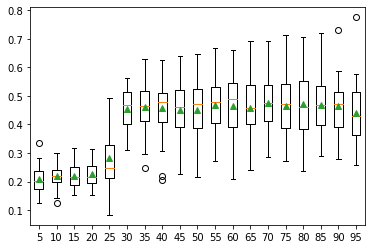

In [24]:
# get the models to evaluate
models = get_models(5, 96, 5)
show_evaluation(models)

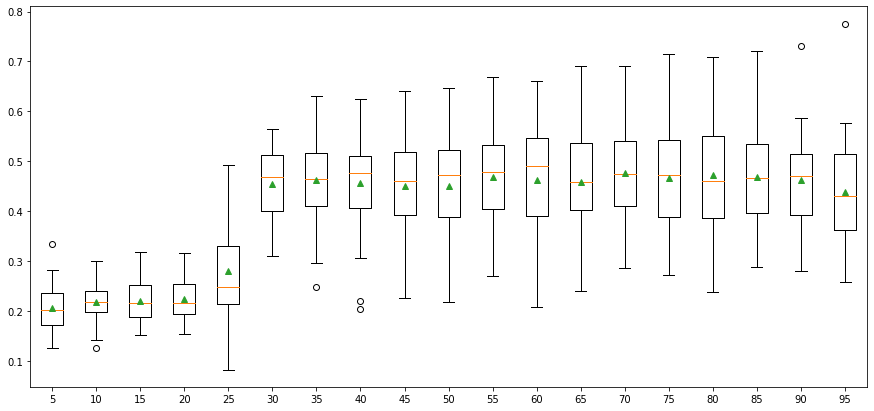

In [26]:
plt.figure(figsize=(15, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

>65 0.458 (0.102)
>66 0.464 (0.093)
>67 0.462 (0.095)
>68 0.466 (0.094)
>69 0.460 (0.100)
>70 0.478 (0.091)
>71 0.463 (0.090)
>72 0.471 (0.109)
>73 0.468 (0.103)
>74 0.467 (0.107)
>75 0.466 (0.102)
>76 0.467 (0.101)
>77 0.474 (0.112)
>78 0.477 (0.107)
>79 0.479 (0.102)
>80 0.472 (0.100)
>81 0.475 (0.095)
>82 0.475 (0.101)
>83 0.467 (0.106)
>84 0.465 (0.096)
>85 0.469 (0.097)


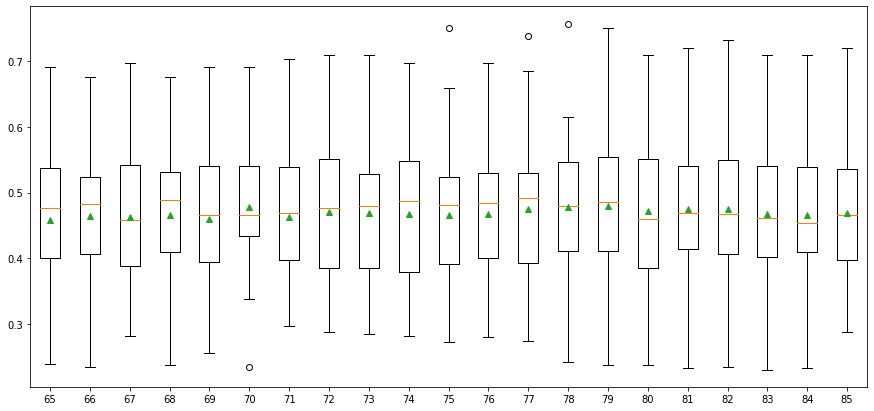

In [16]:
models = get_models(65, 85, 1)
show_evaluation(models)

>86 0.479 (0.096)
>87 0.473 (0.096)
>88 0.469 (0.094)
>89 0.464 (0.090)
>90 0.463 (0.091)
>91 0.468 (0.088)
>92 0.457 (0.098)
>93 0.461 (0.097)
>94 0.465 (0.094)
>95 0.439 (0.111)


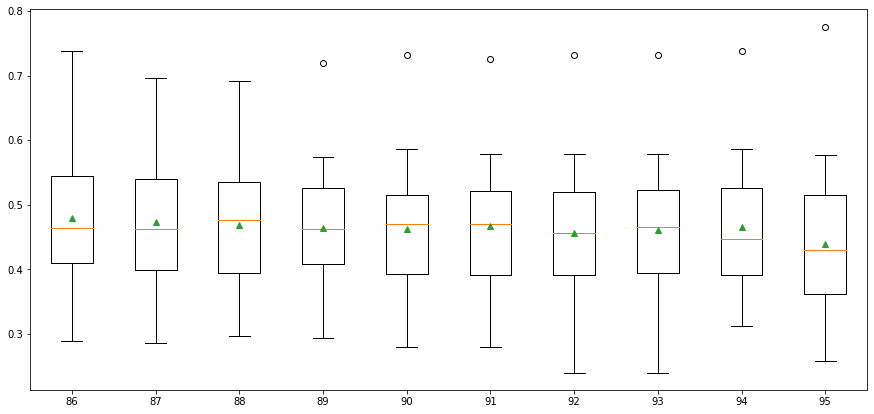

In [17]:
models = get_models(86, 95, 1)
show_evaluation(models)

In [17]:
search.fit(X_train, y_train)

Fitting 30 folds for each of 11 candidates, totalling 330 fits
[CV 1/30] END pca__n_components=79, smote__sampling_strategy=0.95;, score=0.560 total time=   5.1s
[CV 2/30] END pca__n_components=79, smote__sampling_strategy=0.95;, score=0.388 total time=   5.1s
[CV 3/30] END pca__n_components=79, smote__sampling_strategy=0.95;, score=0.474 total time=   5.2s
[CV 4/30] END pca__n_components=79, smote__sampling_strategy=0.95;, score=0.398 total time=   5.1s
[CV 5/30] END pca__n_components=79, smote__sampling_strategy=0.95;, score=0.505 total time=   5.1s
[CV 6/30] END pca__n_components=79, smote__sampling_strategy=0.95;, score=0.357 total time=   5.1s
[CV 7/30] END pca__n_components=79, smote__sampling_strategy=0.95;, score=0.484 total time=   5.1s
[CV 8/30] END pca__n_components=79, smote__sampling_strategy=0.95;, score=0.488 total time=   5.1s
[CV 9/30] END pca__n_components=79, smote__sampling_strategy=0.95;, score=0.536 total time=   5.1s
[CV 10/30] END pca__n_components=79, smote__sa

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=42),
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('smote', SMOTE(random_state=42)),
                                       ('xgb',
                                        XGBClassifier(random_state=42))]),
             param_grid={'pca__n_components': [79, 86, 70, 78, 82, 81, 77, 87,
                                               80, 72, 95],
                         'smote__sampling_strategy': [0.95]},
             scoring=make_scorer(fbeta_score, beta=2), verbose=4)

In [18]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)

Best parameter (CV score=0.476):


In [19]:
best_model = search.best_estimator_
print(best_model)

Pipeline(steps=[('pca', PCA(n_components=82, random_state=42)),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.95)),
                ('xgb', XGBClassifier(random_state=42))])


In [20]:
# Prediction
y_pred = best_model.predict(X_test)
y_score = best_model.predict_proba(X_test)[:, 1]

In [21]:
# Evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1320
           1       0.23      0.66      0.34        44

    accuracy                           0.92      1364
   macro avg       0.61      0.79      0.65      1364
weighted avg       0.96      0.92      0.94      1364

[[1222   98]
 [  15   29]]


In [22]:
#print(f1_score(y_test, y_pred))
#print(roc_auc_score(y_test, y_pred))

print(fbeta_score(y_test, y_pred, beta=2.0))
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
print(auc(recall, precision))

0.47854785478547845
0.376921698556864


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


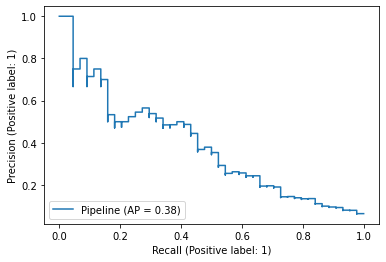

In [23]:
disp = plot_precision_recall_curve(best_model, X_test, y_test)

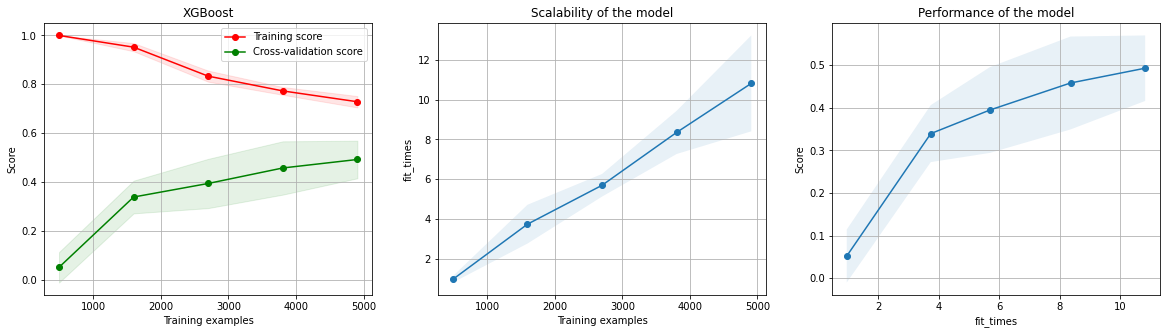

In [28]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        scoring=ftwo_scorer,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times") 
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

if __name__ == '__main__':
    title = "XGBoost"

    plot_learning_curve(
        best_model, title, X_train, y_train, cv=10, n_jobs=-1
    )

    plt.show()